In [1]:
import chess
import numpy as np
import pandas as pd
import pickle
from datasets import load_dataset
import os

Our data begins as a bunch of PGN transcripts. However, to work in tensors we need all transcripts to be the same length. So, this file takes our PGNs and performs some filtering.

This notebook has a very similar counterpart, `stockfish_data_filtering.ipynb`. The lichess and stockfish datasets have a slightly different structure and different column names. For most peoples' needs, the lichess dataset alone should suffice, so I made two separate notebooks to keep this one simple.

In [2]:
DATA_DIR = "data/"
prefix = "lichess_"
# prefix = "lichess_200k_bins_"


input_file = f'{DATA_DIR}{prefix}100mb.csv'
output_file = input_file.replace(".csv", "_filtered.csv")

First, we download the dataset if not present.

In [3]:
if not os.path.exists(input_file):
    dataset_path = "adamkarvonen/chess_games"
    file_path = f"{prefix}100mb.zip"
    dataset = load_dataset(dataset_path, data_files=file_path)
    df = pd.DataFrame(dataset['train'])
    df.to_csv(input_file, index=False)

c:\Users\adamk\anaconda3\envs\interp\lib\site-packages\huggingface_hub\repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Our LLMs need a delimiter token ";" at the beginning of every PGN string or it won't work as well.

In [4]:
df = pd.read_csv(input_file)

def format_transcript(game: str) -> str:
    new_game = ';' + game
    return new_game

df['transcript'] = df['transcript'].apply(format_transcript)

for game in df.head()['transcript']:
    print(game)
    print()

;1.d4 e6 2.Nf3 Qf6 3.Qd3 Bd6 4.c4 b6 5.c5 Be7 6.cxb6 axb6 7.Nc3 Bb7 8.e4 Bd8 9.e5 Qf5 10.Be2 Bxf3 11.Qxf5 exf5 12.Bxf3 c6 13.Bxc6 Nxc6 14.Nb5 Ra7 15.Nd6+ Ke7 16.Nb7 Bc7 17.Bg5+ Ke6 18.d5+ Kxe5 19.dxc6 dxc6 20.Nd8 Bxd8 21.Be3 Bh4 22.O-O Ra6 23.g3 Bd8 24.f4+ Ke6 25.Rad1 Nf6 26.Rxd8 Rxd8 27.Bd4 c5 28.Bxf6 gxf6 29.Rf3 Rd2 30.Rf2 Rd1+ 31.Rf1 Rxf1+ 32.Kxf1 Rxa2 33.Kf2 Rxb2+ 34.Kf3 c4 35.Ke3 c3 36.Kd3 c2 37.Kd2 b5 38.Kc1 b4

;1.e4 d5 2.exd5 Qxd5 3.Nc3 Qd8 4.Nf3 Nf6 5.d4 c5 6.d5 e6 7.dxe6 Qxd1+ 8.Nxd1 Bxe6 9.Bg5 Nbd7 10.Bb5 Be7 11.Ne3 a6 12.Bxd7+ Nxd7 13.Bxe7 Kxe7 14.O-O-O Rhe8 15.Rhe1 Rad8 16.Nd5+ Kf8 17.Nc7 Re7 18.Nxe6+ Rxe6 19.Rxe6 fxe6 20.Ne5 Ke7 21.Nc4 b6 22.f4 b5 23.Na5 Ke8 24.Nc6 Rc8 25.Na5 e5 26.fxe5 c4 27.Re1 Ke7 28.e6 Nc5 29.b3 c3 30.a3 Nxe6 31.b4 Kf6 32.Nb3 Rd8 33.Rf1+ Kg6 34.Kb1 Rd6 35.h3 Rd5 36.g4 h5 37.gxh5+ Rxh5 38.Rh1 Nf4 39.h4 Kh6 40.Rg1 Rxh4 41.Rf1 Ne2 42.Nc5 Rh2 43.Re1 g5 44.Ne4 g4 45.Nf6 Kg5 46.Ne4+ Kf4 47.Nd6 Ke3 48.Rd1 g3 49.Rd3+ Kf2

;1.g3 d6 2.Bg2 c6 3.c4 f6 4.d4 Be6 5.

Filter all games to be len 365. This means we discard anything under that length. I chose 365 because that's the 50% of df.describe(). I also count the number of moves (with x.split()) and discard anything below the 25th percentile. This makes it easier if I want to do any move based indexing.

In [5]:
len_df = df['transcript'].apply(lambda x: len(x))
print(len_df.describe())

game_length_in_chars = 365

# Data setup. All games must have same length. 50% are >= 690 moves. I will discard all games less than 680, and truncate the rest to 680.
filtered_df = df[df['transcript'].apply(lambda x: len(x) >= game_length_in_chars)].copy()
filtered_df.loc[:, 'transcript'] = filtered_df['transcript'].apply(lambda x: x[:game_length_in_chars])

len_df = filtered_df['transcript'].apply(lambda x: len(x))
print(len_df.describe())

move_count_df = filtered_df['transcript'].apply(lambda x: len(x.split()))
move_count = move_count_df.describe()
print("move count", move_count_df.describe())
quarter_percentile = move_count['25%']
print("quarter percentile", quarter_percentile)

# Now I need to filter out games that are too short. I will discard all games less than 25th percentile  moves.
filtered_df = filtered_df[filtered_df['transcript'].apply(lambda x: len(x.split()) >= quarter_percentile)]
print(filtered_df.describe())
print(filtered_df.head())

filtered_df.to_csv(output_file, index=False)

move_count_df = filtered_df['transcript'].apply(lambda x: len(x.split()))
print(move_count_df.describe())

count    258000.000000
mean        393.949275
std         164.818565
min         137.000000
25%         270.000000
50%         365.000000
75%         491.000000
max        2361.000000
Name: transcript, dtype: float64
count    129151.0
mean        365.0
std           0.0
min         365.0
25%         365.0
50%         365.0
75%         365.0
max         365.0
Name: transcript, dtype: float64
move count count    129151.000000
mean         66.530023
std           1.209119
min          62.000000
25%          66.000000
50%          67.000000
75%          67.000000
max          72.000000
Name: transcript, dtype: float64
quarter percentile 66.0
       Unnamed: 0.1    Unnamed: 0       WhiteElo       BlackElo
count  4.909300e+04  1.010570e+05  101057.000000  101057.000000
mean   8.160979e+06  8.053154e+06    1816.450696    1797.667633
std    4.767164e+06  6.198925e+06     407.422681     370.036528
min    7.640000e+02  3.400000e+01     780.000000     759.000000
25%    4.031268e+06  3.059881e+06 

In [6]:
print(len(filtered_df))
print(filtered_df['WhiteElo'].describe())

101057
count    101057.000000
mean       1816.450696
std         407.422681
min         780.000000
25%        1501.000000
50%        1857.000000
75%        2150.000000
max        3161.000000
Name: WhiteElo, dtype: float64


For the classification task, I wanted some Elo bins for the probe to classify. This somewhat arbitrarily creates 6 different Elo bins.

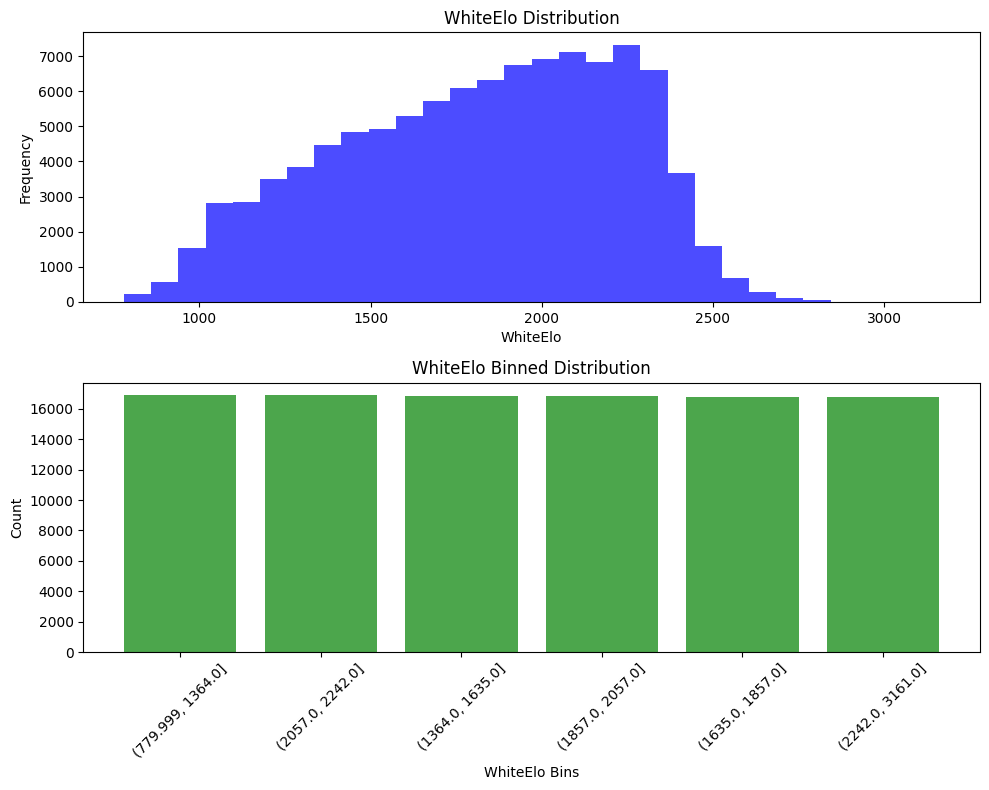

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

# Function to create binned columns and bin index columns
def create_binned_columns(df, column_name):
    binned_column_name = f'{column_name}Binned'
    bin_index_column_name = f'{column_name}BinIndex'
    
    # Create quantile-based bins
    num_bins = 6
    # Create quantile-based bins with range labels, dropping duplicates if necessary
    df[binned_column_name], bins = pd.qcut(df[column_name], q=num_bins, retbins=True, duplicates='drop')

    # Convert bin labels to strings and assign to the column
    df[binned_column_name] = df[binned_column_name].apply(lambda x: f'({x.left}, {x.right}]')

    # Create bin index column
    df[bin_index_column_name] = pd.qcut(df[column_name], q=num_bins, labels=False, duplicates='drop')

# Apply the function to both WhiteElo and BlackElo
create_binned_columns(filtered_df, 'WhiteElo')
create_binned_columns(filtered_df, 'BlackElo')

filtered_df.to_csv(output_file, index=False)

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Histogram for WhiteElo
axes[0].hist(filtered_df['WhiteElo'], bins=30, color='blue', alpha=0.7)
axes[0].set_title('WhiteElo Distribution')
axes[0].set_xlabel('WhiteElo')
axes[0].set_ylabel('Frequency')

# Bar chart for WhiteEloBinned
bin_counts = filtered_df['WhiteEloBinned'].value_counts()
axes[1].bar(bin_counts.index.astype(str), bin_counts.values, color='green', alpha=0.7)
axes[1].set_title('WhiteElo Binned Distribution')
axes[1].set_xlabel('WhiteElo Bins')
axes[1].set_ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



In [8]:
print(filtered_df['WhiteEloBinned'].value_counts())

WhiteEloBinned
(779.999, 1364.0]    16891
(2057.0, 2242.0]     16888
(1364.0, 1635.0]     16859
(1857.0, 2057.0]     16859
(1635.0, 1857.0]     16788
(2242.0, 3161.0]     16772
Name: count, dtype: int64


In [9]:
print(filtered_df.head())

    Unnamed: 0.1  Unnamed: 0  WhiteElo  BlackElo Result  \
1            NaN    17636104      2061      2048    0-1   
6       240358.0      240358      1824      1843    1-0   
8            NaN     6682990      2415      2154    0-1   
13           NaN     3379655      2016      1826    0-1   
16     2856389.0     2856389      1297      1450    0-1   

                                           transcript       elo_bin  \
1   ;1.e4 d5 2.exd5 Qxd5 3.Nc3 Qd8 4.Nf3 Nf6 5.d4 ...  [2000, 2100)   
6   ;1.c4 e5 2.e3 d6 3.b3 Nf6 4.Bb2 Be6 5.Nc3 c6 6...  [1800, 1900)   
8   ;1.d4 c5 2.c4 cxd4 3.Nf3 d5 4.cxd5 Nf6 5.Qxd4 ...  [2400, 2500)   
13  ;1.e4 e5 2.Nf3 d6 3.Bc4 Be7 4.O-O Nf6 5.d3 h6 ...  [2000, 2100)   
16  ;1.c4 d6 2.d4 Bf5 3.Nc3 c6 4.e4 Bg6 5.d5 Nf6 6...  [1200, 1300)   

       WhiteEloBinned  WhiteEloBinIndex    BlackEloBinned  BlackEloBinIndex  
1    (2057.0, 2242.0]                 4  (1994.0, 2174.0]                 4  
6    (1635.0, 1857.0]                 2  (1827.0, 1994.0]     

In [10]:
# shuffle all rows of the dataset

df = pd.read_csv(output_file)
df = df.sample(frac=1, random_state=200).reset_index(drop=True)
df.to_csv(output_file, index=False)

In [11]:
import pandas as pd
df = pd.read_csv(output_file)

print(len(df))

# Split df into a train and test split
train = df.sample(frac=0.9, random_state=200)
test = df.drop(train.index)

print(len(train))
print(len(test))

# Save the train and test splits to csv
train.to_csv(f'{DATA_DIR}{prefix}train.csv', index=False)
test.to_csv(f'{DATA_DIR}{prefix}test.csv', index=False)

101057
90951
10106
